# Tarea 2: ¿Es posible explicar la cantidad de billonarios en base al desarrollo país?  <a class="tocSkip"></a>







En 2006 *Daniel Treisman* publicó un artículo titulado [*Russia Billionaries*](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.p20161068) en el cual conectó la cantidad de billonarios de un país con ciertos atributos económicos de los mismos. 

Su conclusión principal fue que Rusia tiene una cantidad de billonarios mayor que la que predicen los indicadores económicos

En esta tarea ustedes analizarán datos macroeconómicos para comprobar o refutar los hallazgos de *D. Treisman*

## Instrucciones generales 

1. Forme un grupo de **máximo tres estudiantes**
1. Versione su trabajo usando un **repositorio privado de github**. Agregue a sus compañeros y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas de programación si no se cumple este requisito
1. Su tarea se evaluará en base al último commit antes de la fecha de entrega: **14:10 del Martes 15 de Junio de 2021**. La nota se calcula como ("pt totales" + 1)
1. [Sean leales y honestos](https://www.acm.org/about-acm/code-of-ethics-in-spanish), no copie ni comparta resultados con otros grupos

## Datos

Para esta tarea se les provee de un conjunto de datos `billonarios.csv` indexado por país con los siguientes atributos

- `nbillonarios`: La cantidad de billonarios del pais
- `logpibpc`: El logaritmo del Producto Interno Bruto (PIB) per capita del pais
- `logpob`: El logaritmo de la población del pais
- `gatt`: La cantidad de años que el pais está adherido al *General Agreement on Tariffs and Trade* (GATT)

## Modelo (1.0pt)

El objetivo principal de esta tarea es entrenar un modelo de regresión que prediga la cantidad de billonarios en función de los demás atributos

> El número de billonarios es una variable entera y no-negativa. 

Un modelo apropiado en este caso es la [regresión de Poisson](https://en.wikipedia.org/wiki/Poisson_distribution), donde definimos la probabilidad condicional para un pais $i$ como  

$$
p(y_i | x_i ) = \frac{\lambda_i^{y_i}}{y_i!} \exp \left ({-\lambda_i} \right)
$$

con intensidad

$$
\lambda_i = \exp \left (\theta_0 + \sum_{j=1}^M \theta_j x_{ij} \right)
$$

donde 

- $\theta$ es el vector de parámetros que deseamos ajustar 
- $y_i$ y $x_i$ son la cantidad de billonarios y el vector de atributos del país $i$, respectivamente

En base a este modelo se pide que ajusten $\theta$ mediante la maximización de la verosimilitud. 

$$
\begin{align}
\hat \theta &= \text{arg}\max_\theta \log \mathcal{L} (\theta) \nonumber \\ 
&= \text{arg}\max_\theta \log \prod_{i=1}^N  p(y_i | x_i) \nonumber \\
&= \text{arg}\max_\theta \sum_{i=1}^N \log p(y_i | x_i) \nonumber
\end{align}
$$

En particular:

1. Estudie y describa la distribución de Poisson en detalle. Muestre como varía la distribución en función de su parámetro $\lambda$, ¿Qué ocurre cuando $\lambda$ es pequeño? ¿Y cuando es grande?
1. Reemplace las expresiones y obtenga una expresión analítica para el logaritmo de la verosimilitud: $\log \mathcal{L}(\theta)$. Muestre la ecuación obtenida. HINT: Puede ignorar los términos que no dependan de $\theta$. Luego obtenga una expresión analítica para la primera derivada del logaritmo de la verosimilitud. Muestra la ecuación obtenida

# 1

In [294]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import factorial
from IPython.display import YouTubeVideo
from functools import partial
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets

Creamos la función ```poisson``` la cual contiene el parámetro ```y``` que contiene un array con la cantidad de billonarios por país y ```lamb``` que representará a $\lambda$

In [331]:
def poisson(y, lamb = 1):
    op_1 = np.power(lamb, y)/factorial(y)
    op_2 = np.power(np.e,-lamb)
    return op_1*op_2

Cargamos la csv de billonarios y creamos una variable ```Y``` que contiene la cantidad de billonarios

In [332]:
df = pd.read_csv('billonarios.csv', index_col=0)
Y = df["nbillonarios"].values

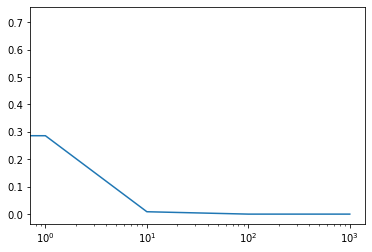

In [387]:
arr = np.array([poisson(Y, 0).mean(), 
                poisson(Y, 1).mean(), 
                poisson(Y, 10).mean(), 
                poisson(Y, 100).mean(), 
                poisson(Y, 1000).mean()])
fig, ax = plt.subplots()
plt.semilogx()
ax.plot(np.array([0,1,10,100,1000]), arr);

R: A medida que aumenta $\lambda$, la distribución de poisson se acerca a 0

Otra forma de verlo es el siguiente

$$
\lim_{\lambda_i \to \infty} p(y_i|x_i)
\\
= \lim_{\lambda_i \to \infty} \frac{\lambda_i^{y_i}}{y_i!} \cdot e^{-\lambda_i}
\\
= \lim_{\lambda_i \to \infty} \frac{\lambda_i^{y_i}}{y_i!} \cdot \frac{1}{e^{\lambda_{i}}}
\\
= \lim_{\lambda_i \to \infty} \frac{\lambda_i^{y_i}}{e^{\lambda_i}} \cdot \frac{1}{y_i!}
\\
= \frac{1}{y_i!} \cdot \lim_{\lambda_i \to \infty} \frac{\lambda_i^{y_i}}{e^{\lambda_i}}
\\
= \frac{1}{y_i!} \cdot \lim_{\lambda_i \to \infty} \frac{\lambda_i^{y_i}}{e^{\lambda_i}}
\\
= \frac{1}{y_i!} \cdot 0 = 0
\\
\therefore \lim_{\lambda_i \to \infty} p(y_i|x_i) = 0
$$

# 2

![](IMG_20210617_022028.jpg)

## Implementación (1.5pt)

1. Implemente el logaritmo de la verosimilitud y su derivada usando `numpy`. Utilice operaciones vectoriales (prohibido usar `for` para iterar en los países)
1. Implemente una rutina que encuentre el vector de parámetros óptimo en base a `scipy.optimize.minimize` 
1. Implemente una rutina que calcule el pseudo coeficiente de correlación
$$
R^2 = \frac{\log \mathcal{L} (\hat \theta_0) - \log \mathcal{L} (\hat \theta) }{\log \mathcal{L} (\hat \theta_0)} \in [0, 1]
$$
donde $\log \mathcal{L} (\hat \theta)$ es el logaritmo de la verosimilitud de su mejor modelo y $\log \mathcal{L} (\hat \theta_0)$ es el logaritmo de la verosimilitud de un modelo que tiene sólo el parámetro $\theta_0$
1. Implemente una rutina de bootstrap resampling para encontrar la distribución y los intervalos de confianza empíricos para $\theta$ y el pseudo coeficiente de correlación


# 1

In [424]:
def L(df):
    N = len(df)
    sum = 0
    for i in range(N):
        sum += poissonxy(df, i)
    return sum

In [425]:
def poissonxy(df, i):
    y = df.nbillonarios[i]
    op_1 = np.power(lamb(df, i), y)/factorial(y)
    op_2 = np.power(np.e, -lamb(df, i))
    return op_1*op_2

In [426]:
def lamb(df, i):
    M = len(df.columns)-1
    theta = 0
    sum = 0
    for j in range (M):
        #sum += theta_j * x[i,j]
        sum = 1
    return theta+sum

## Resultados (3pt)

1. Compare los métodos `CG`, `BFGS`, `Nelder-mead` y `Powell` en términos del vector de parámetros obtenido, la log verosimilitud alcanzada, el pseudo coeficiente de correlación alcanzado, el número de iteraciones necesarias para converger y el tiempo total para converger. Seleccione uno de los métodos para contestar los siguientes puntos
1. Muestre las distribuciones empíricas de los parámetros y del pseudo coeficiente de correlación. ¿Cuáles parámetros tienen $\theta$ significativamente distinto de cero? ¿Cuál es el intervalo de confianza al 95% del $R^2$? En base a esto ¿Qué puede decir sobre su modelo?
1. Prediga la cantidad de billonarios de cada país usando su modelo. Gráfique el error entre la cantidad de billonarios predicha y la cantidad de billonarios real. El gráfico debe mostrar los paises ordenados de mayor a menor **error absoluto**.  Analice ¿Cuáles son los 5 países con mayor error en la predicción? ¿Cuáles países tienen un exceso de billonarios? ¿Cúales paises tienen menos billonarios de lo esperado? ¿Qué puede decir sobre Rusia?



## Conclusiones (0.5pt)

Resuma sus principales hallazgos y comenté sobre las desafios encontrados al desarrollar esta tarea 